<a href="https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to GPU programming with Numba

This notebook includes content from [seibert's 2018 gtc numba tutorial](https://github.com/ContinuumIO/gtc2018-numba). I highly recommend that tutorial in its entireity if you want more practice with Numba and GPUs.

##What is Numba?

According to the [Numba documentation](https://numba.pydata.org/numba-doc/latest/user/index.html), "Numba is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions, and loops. The most common way to use Numba is through its collection of decorators that can be applied to your functions to instruct Numba to compile them. When a call is made to a Numba decorated function it is compiled to machine code “just-in-time” for execution and all or part of your code can subsequently run at native machine code speed!"

For our purposes today, Numba is a python package that allows you to write python code for GPUs.

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
from numba import jit, njit, vectorize, cuda

### Accessing the GPU

1) In order to run Numba functions using google's free GPUs, we have to do a couple of things. First, go to the Runtime menu, click on 'Change Runtime Type', and in the pop-up box, under 'Hardware Accelerator', select 'GPU'. Save the Runtime.

2) Ideally, that's all we should have to do. But in practice, even though the CUDA libararies are installed, as of this writing Colab can't find them automatically. So, we'll figure out where they are, and then point Colab to them.

In [0]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/cuda-10.0/nvvm/libdevice
/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so


Paste the location of the libraries into the following code box (if it's different, otherwise you can just run the code):

In [0]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

### Vector Addition on GPUs

The simplest way to access the GPU via Numba is to use a vectorized ufunc. A Numpy ufunc, or [Universal Function,](https://docs.scipy.org/doc/numpy/reference/ufuncs.html) is a function that operates on vectors, or arrays. If we use Numba's `vectorize` decorator and specify the `cuda` target, Numba will automatically write a CUDA kernel for us and run the function on the GPU! Let's try it out:

In [0]:
@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc_gpu(x, y):
    return x + y

In [0]:
x = np.arange(10)
y = 2 * x

In [0]:
add_ufunc_gpu(x, y)

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27])

Cool, it worked! But what actually just happened? Well, a lot of things. Numba automatically:
+ Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
+ Allocated GPU memory for the inputs and the output.
+ Copied the input data to the GPU.
+ Executed the CUDA kernel with the correct kernel dimensions given the input sizes.
+ Copied the result back from the GPU to the CPU.
+ Returned the result as a NumPy array on the host.

Using the `%timeit` magic function, we can determine how fast the CUDA function is:

In [0]:
%timeit add_ufunc_gpu(x, y)

The slowest run took 5.99 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 755 µs per loop


And compare it to a version compiled for the CPU:

In [0]:
@vectorize(['int64(int64, int64)'], target='cpu')
def add_ufunc_cpu(x, y):
    return x + y
%timeit add_ufunc_cpu(x, y)

The slowest run took 32.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 617 ns per loop


Wow, the GPU is a LOT slower! That's because we have (deliberately) misused the GPU in several ways in this example:
+ **Our inputs are too small**: the GPU achieves performance through parallelism, operating on thousands of values at once. Our test inputs have only 10 integers. We need a much larger array to even keep the GPU busy.
+ **Our calculation is too simple**: Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU. If our calculation does not involve enough math operations ("arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
+ **We copy the data to and from the GPU**: While including the copy time can be realistic for a single function, often we want to run several GPU operations in sequence. In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
+ **Our data types are larger than necessary**: Our example uses int64 when we probably don't need it. Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, but 64-bit data types have a significant performance cost on the GPU. Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats. NumPy defaults to 64-bit data types when creating arrays, so it is important to set the dtype attribute or use the ndarray.astype() method to pick 32-bit types when you need them.



### Writing Cuda Kernels

While targeting ufuncs with the `cuda` syntax is the most straightforward way to access the GPU with Numba, it may not be flexible enough for your needs. If you want to write a more detailed GPU program, at some point you are probably going to need to write CUDA kernels.

As discussed in the lecture, the CUDA programming model allows you to abstract the GPU hardware into a software model composed of a **grid** containing **blocks** of **threads**. These threads are the smallest individual unit in the programming model, and they execute together in groups (traditionally called **warps**, consisting of 32 threads each). Determiming the best size for your grid of thread blocks is a complicated problem that often depends on the specific algorithm and hardware you're using, but here a few good rules of thumb:
+ the size of a block should be a multiple of 32 threads, with typical block sizes between 128 and 512 threads per block.
+ the size of the grid should ensure the full GPU is utilized where possible. Launching a grid where the number of blocks is 2x-4x the number of **streaming multiprocessors** on the GPU is a good starting place. (The Tesla K80 GPUs provided by Colaboratory have 15 SMs - more modern GPUs like the P100s on TigerGPU have 60+.)
+ The CUDA kernel launch overhead does depend on the number of blocks, so it may not be best to launch a grid where the number of threads equals the number of input elements when the input size is very big. We'll show a pattern for dealing with large inputs below.

As a first example, let's return to our vector addition function, but this time, we'll target it with the `cuda.jit` decorator:

In [0]:
@cuda.jit
def add_kernel(x, y, out):
    tidx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    bidx = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_dimx = cuda.blockDim.x  # number of threads per block
    grid_dimx = cuda.gridDim.x    # number of blocks in the grid
    
    start = tidx + bidx * block_dimx
    stride = block_dimx * grid_dimx

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

That's a lot more typing than our ufunc example, and it is much more limited: it only works on 1D arrays, it doesn't verify input sizes match, etc. Most of the function is spent figuring out how to turn the block and grid indices and dimensions into unique offsets in the input arrays. The pattern of computing a starting index and a stride is a common way to ensure that your grid size is independent of the input size. The striding will maximize bandwidth by ensuring that threads with consecuitive indices are accessing consecutive memory locations as much as possible. Thread indices beyond the length of the input (x.shape[0], since x is a NumPy array) automatically skip over the for loop.

Let's call the function now on some data:

In [0]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


The calling syntax is designed to mimic the way CUDA kernels are launched in C, where the number of blocks per grid and threads per block are specified in the square brackets, and the arguments to the function are specified afterwards in parentheses.

Note that, unlike the ufunc, the arguments are passed to the kernel as full NumPy arrays. A thread within the kernel can access any element in the array it wants, regardless of its position in the thread grid. This is why CUDA kernels are significantly more powerful than ufuncs. (But with great power, comes a greater amount of typing...)

Numba has created some [helper functions](http://numba.pydata.org/numba-doc/dev/cuda/kernels.html#absolute-positions) to cut down on the typing. We can write the previous kernel much more simply as:

In [0]:
@cuda.jit
def add_kernel(x, y, out):
    start = cuda.grid(1)      # the 1 argument means a one dimensional thread grid, this returns a single value
    stride = cuda.gridsize(1) # ditto

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

As before, using NumPy arrays forces Numba to allocate GPU memory, copy the arguments to the GPU, run the kernel, then copy the argument arrays back to the host. This not very efficient, so you will often want to pre-allocate device arrays.

### Memory Management

Numba can automatically handle transferring data to and from the GPU for us. However, that's not always what we want. Sometimes we will want to perform several functions in a row on the GPU without transferring the data back to the CPU in between. To address this, Numba provides the `to_device` function in the `cuda` module to allocate and copy arrays to the GPU:

In [0]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


`x_device` and `y_device` are now Numba "device arrays" that are in many ways equivalent to Numpy ndarrays except that they live in the GPU's global memory, rather than on the CPU. These device arrays can be passed to Numba cuda functions just the way Numpy arrays can, but without the memory copying overhead.

We can also create an output buffer on the GPU with the numba.cuda.device_array() function:

In [0]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, much like np.empty()

Now we can try out our Cuda kernel using the pre-copied device arrays, and compare the time to a version without moving the data first.

In [0]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)

The slowest run took 884.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 184 µs per loop


In [0]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)

The slowest run took 121.67 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.32 ms per loop


As you can see, moving data back and forth is *expensive*. In general, you will want to keep your data on the GPU as long as possible and do as many calculations as you can before moving it back. Of course, at some point you will have to move the data back to the CPU, whether to output to a file, perform some other CPU functions, etc.. Numba provides the `copy_to_host` function for that:

In [0]:
out = out_device.copy_to_host()

After all of this extra work, you may be wondering what the point of doing calculations on the GPU is. After all, if we compare the time it takes to run our fancy Cuda kernel with the pre-allocated GPU arrays, to the CPU version provided by python, we find that the GPU version is still faster:

In [0]:
%timeit x + y

The slowest run took 7.13 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 78 µs per loop


But that's because we *still* haven't given the GPU enough work to do. If we go back and try the same problem, but with arrays that are 10 times larger...

In [0]:
n = 1000000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [0]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)
out_device = cuda.device_array(shape=(n,), dtype=np.float32)

In [0]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)

The slowest run took 7.72 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 177 µs per loop


In [0]:
%timeit x + y

The slowest run took 9.35 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 709 µs per loop


...we start to see the power of the GPU. As you may have noticed, the GPU function called with a million array elements took approximately the same amount of time to run as the version with 100 thousand elements. That's because most of the GPU was not busy when we only had 100 thousand elements, so we still hadn't overcome the overhead of launching the kernel.

### Fun with Fractals

This is a short tutorial, but to give you an idea of an area where GPUs shine, let's play around with some slightly more complicated functions designed to create fractals. Below are two functions that create an instance of the Julia set:

In [0]:
def julia(x, y, max_iters):
  """
  Given the real and imaginary parts of a complex number,
  determine if it is a candidate for membership in the Julia
  set given a fixed number of iterations.
  """
  i = 0
  c = complex(-0.8, 0.156)
  a = complex(x,y)
  for i in range(max_iters):
    a = a*a + c
    if (a.real*a.real + a.imag*a.imag) > 1000:
      return int((i/max_iters)*255)
  return 255

In [0]:
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = julia(real, imag, iters)
      image[y, x] = color

  return image

1 loop, best of 3: 2.91 s per loop


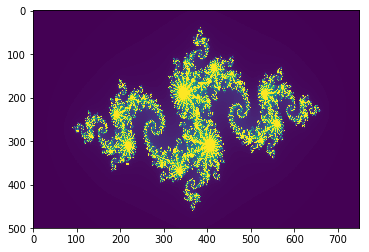

In [0]:
image = np.zeros((500, 750), dtype=np.uint8)
%timeit create_fractal(-2.0, 2.0, -1.0, 1.0, image, 200)
plt.imshow(image)
plt.viridis()
plt.show()

In order to turn this into a GPU implementation, we need to have a kernel function (create_fractal) call another function (julia) on the device. Numba has a way of specifying functions that will be called from within a kernel by passing the cuda.jit decorator the `device` argument:

In [0]:
@cuda.jit(device=True)
def julia(x, y, max_iters):
  """
  Given the real and imaginary parts of a complex number,
  determine if it is a candidate for membership in the Julia
  set given a fixed number of iterations.
  """
  i = 0
  c = complex(-0.8, 0.156)
  a = complex(x,y)
  for i in range(max_iters):
    a = a*a + c
    if (a.real*a.real + a.imag*a.imag) > 1000:
      return int((i/max_iters)*255)
  return 255

#### Multi-dimensional grids

For some problems, it makes sense to define a two- or three-dimensional grid of thread blocks. That way, when you're indexing a single thread, you can map it to, say, the pixel position in an image. Multi-dimensional grids are created by passing tuples to the kernel function. You can ensure that you launch a big enough grid by calculating the size of each dimension as a function of the array size and number of threads per block:

In [0]:
threadsperblock = 16
xblocks = (image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (image.shape[0] + (threadsperblock - 1)) // threadsperblock

Then, within a kernel, you can determine the absolute thread position by calling the `grid` helper function, as in `x, y = cuda.grid(2)`.

Below is a modified version of the create_fractal function that launches as a kernel on the GPU and calls the device function, julia. We use a 2D grid of thread blocks to launch the kernel and determine which threads are responsible for each pixel in the image.

In [0]:
@cuda.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  x, y = cuda.grid(2)
    
  if x < width and y < height:
    real = min_x + x * pixel_size_x
    imag = min_y + y * pixel_size_y
    color = julia(real, imag, iters)
    image[y, x] = color

In [0]:
image = np.zeros((500, 750), dtype=np.uint8)
threadsperblock = 16
threads_per_block = (16, 16)
xblocks = (image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (image.shape[0] + (threadsperblock - 1)) // threadsperblock
blocks_per_grid = (xblocks, yblocks)

The slowest run took 75.37 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.65 ms per loop


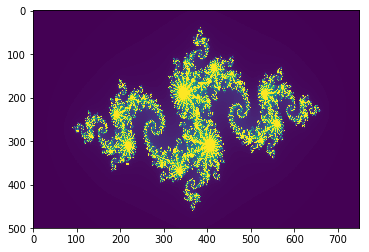

In [0]:
%timeit create_fractal[blocks_per_grid, threads_per_block](-2.0, 2.0, -1.0, 1.0, image, 200)
plt.imshow(image)
plt.viridis()
plt.show()

How does the GPU implementation compare to the CPU version?